In [1]:
from fastmcp import Client

from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

In [2]:
client = Client("http://localhost:8001/mcp")

async with client:
    tools = await client.list_tools()

In [3]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_formatted_item_context
Get the top k context, each representing an inventory item for a given query.

Args:
    query: The query to get the top k context for
    top_k: The number of context chunks to retrieve, works best with 5 or more
 
Returns:
    A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.
{'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}


In [4]:
client = Client("http://localhost:8002/mcp")

async with client:
    tools = await client.list_tools()

In [5]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_formatted_review_context
Get the top k reviews matching a query for a list of prefiltered items.

Args:
    query: The query to get the top k reviews for
    item_list: The list of item IDs to prefilter for before running the query
    top_k: The number of reviews to retrieve, this should be at least 20 if multipple items are prefiltered

Returns:
    A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.
{'properties': {'query': {'title': 'Query', 'type': 'string'}, 'item_list': {'items': {'type': 'string'}, 'title': 'Item List', 'type': 'array'}, 'top_k': {'default': 20, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query', 'item_list'], 'type': 'object'}


### Execute a tool on one of the running MCP servers

In [6]:
client = Client("http://localhost:8001/mcp")

async with client:
    # List available resources
    result = await client.call_tool("get_formatted_item_context", {"query": "earphones", "top_k": 5})

In [7]:
result

CallToolResult(content=[TextContent(type='text', text="- B0C85LNB75: Wireless Earbuds Headphones Bluetooth 5.3, 50H Playtime Over Ear Buds with Noise Cancelling Mic, LED Display, Stereo Bass Bluetooth Earbuds with Earhooks, IP7 Waterproof Earphones for Sports Workout Superior Clear Call and Immersive Stereo Sound Wireless Earbuds, DETACHABLE EARHOOK FOR SPORTS ONE BUTTON CONTROL DESIGN\n- B09NZNP8Z3: WeurGhy Wireless Earbuds, Bluetooth 5.1 Headphones with HD Microphone, Deep Bass in Ear Sports Earphones with LED Display, 80 Hours of Playtime, IPX7 Waterproof Earbuds for Workout Running Powerful Deep Bass and Clear Calls: Wireless earbuds has four powerful built-in microphones to effectively remove ambient noise and make calls clearer. 10mm speaker drivers provide deep bass and pure midrange for a more authentic music experience. 80 Hours Playtime and Dual LED Displays Charging Case: The wireless headphones can last up to 8 hours at a time and have a portable charging case that allows y

### Function to extract tool definition of all available tools in MCP servers 

In [8]:
def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [9]:
parse_docstring_params(tools[0].description)

{'query': 'The query to get the top k reviews for',
 'item_list': 'The list of item IDs to prefilter for before running the query',
 'top_k': 'The number of reviews to retrieve, this should be at least 20 if multipple items are prefiltered'}

* the output above is not enough informative
* what we want is:\
                result = {\
                    "name": "",\
                    "description": "",\
                    "parameters": {"type": "object", "properties": {}},\
                    "required": [],\
                    "returns": {"type": "string", "description": ""},\
                }


* let's reconstruct it

In [10]:
result = {
    "name": "",
    "description": "",
    "parameters": {"type": "object", "properties": {}},
    "required": [],
    "returns": {"type": "string", "description": ""},
}

result["name"] = tools[0].name
result["required"] = tools[0].inputSchema.get("required", [])

description = tools[0].description.split("\n\n")[0]
result["description"] = description

returns = tools[0].description.split("Returns:")[1].strip()
result["returns"]["description"] = returns

property_descriptions = parse_docstring_params(tools[0].description)
properties = tools[0].inputSchema.get("properties", {})
for key, value in properties.items():
    properties[key]["description"] = property_descriptions.get(key, "")

result["parameters"]["properties"] = properties

* this basically recreates what we got from get_tool_descriptions_from_node \
only now it is retrieved from mcp server

In [11]:
result

{'name': 'get_formatted_review_context',
 'description': 'Get the top k reviews matching a query for a list of prefiltered items.',
 'parameters': {'type': 'object',
  'properties': {'query': {'title': 'Query',
    'type': 'string',
    'description': 'The query to get the top k reviews for'},
   'item_list': {'items': {'type': 'string'},
    'title': 'Item List',
    'type': 'array',
    'description': 'The list of item IDs to prefilter for before running the query'},
   'top_k': {'default': 20,
    'title': 'Top K',
    'type': 'integer',
    'description': 'The number of reviews to retrieve, this should be at least 20 if multipple items are prefiltered'}}},
 'required': ['query', 'item_list'],
 'returns': {'type': 'string',
  'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'}}

* now we want to loop this code for all available tools in mcp server

In [12]:
async def get_tool_descriptions_from_mcp_servers(mcp_servers: list[str]) -> list[dict]:

    tool_descriptions = []

    for server in mcp_servers:
        client = Client(server)

        async with client:

            tools = await client.list_tools()

            for tool in tools:

                result = {
                    "name": "",
                    "description": "",
                    "parameters": {"type": "object", "properties": {}},
                    "required": [],
                    "returns": {"type": "string", "description": ""},
                    "server": server
                }

                result["name"] = tool.name
                result["required"] = tool.inputSchema.get("required", [])

                description = tool.description.split("\n\n")[0]
                result["description"] = description

                returns = tool.description.split("Returns:")[1].strip()
                result["returns"]["description"] = returns

                property_descriptions = parse_docstring_params(tool.description)
                properties = tool.inputSchema.get("properties", {})
                for key, value in properties.items():
                    properties[key]["description"] = property_descriptions.get(key, "")

                result["parameters"]["properties"] = properties

                tool_descriptions.append(result)
                
    return tool_descriptions

In [13]:
mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]

In [14]:
tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)

In [15]:
tool_descriptions

[{'name': 'get_formatted_item_context',
  'description': 'Get the top k context, each representing an inventory item for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'string',
   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_formatted_review_context',
  'description': 'Get the top k reviews matching a query for a list of prefiltered items.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the t

* LET'S TEST IT!
* use simple graph as in '07' notebook

### Agent integration with tools exposed via MCP servers

### Helper function

In [16]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

### State and Pydantic Models for structured outputs

In [17]:
class ToolCall(BaseModel):
    name: str
    arguments: dict
    server: str

class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    iteration: int = Field(default=0)
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: List[RAGUsedContext] = Field(default_factory=list)
    user_intent: str = ""

### The Product QA Agent ?Node

In [18]:
@traceable(
    name="product_qa_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def product_qa_agent_node(state: State) -> dict:

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specificly provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
- You need to answer the question based on the retrieved context using the available tools only.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
- As a final output you need to provide:

* The answer to the question based on the retrieved context.
* The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Short description of the item based on the retrieved context.

- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function name and arguments.
- If you have all the information needed to provide a complete answer, set final_answer to True.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieve_context_ids": response.retrieved_context_ids
   }

### User Intent Router node

In [19]:
class IntentRouterAgentResponse(BaseModel):
    user_intent: str
    answer: str

* note: model changed to gpt-4.1 due to tool calling issues. (needs to be aligned with the main code)

In [20]:
@traceable(
    name="intent_router_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def intent_router_agent_node(state: State) -> dict:

   prompt_template =  """You are a part of a shopping assistant that routes user queries to the appropriate agents.

You will be given a conversation history, your task is to classify the intent of the user's latest query and output an appropriate classification.

The possible intents are:

- product_qa: The user is asking a question about a product. This can be a question about available products, their specifications, user reviews etc.
- other: The user's latest query is not clear or not related to the shopping assistant.

Additional instructions:

- Write the intent classification to the user_intent field.
- If the classification is 'other', you should output the answer to the user's query trying to clarify the user's intent.
- If the classification is 'product_qa', you should only output the intent classification and no other text."""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=IntentRouterAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.user_intent == "product_qa":
      ai_message = []
   else:
      ai_message = [AIMessage(
         content=response.answer,
      )]

   return {
      "messages": ai_message,
      "answer": response.answer,
      "user_intent": response.user_intent
   }

### The Tool Use Router node

In [21]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

### User Intent Router

In [22]:
def user_intent_router(state: State) -> str:
    """Decide whether to continue or end"""

    if state.user_intent == "product_qa":
        return "product_qa_agent"
    else:
        return "end"

### Custom tool node function that supports running tools exposed via MCP Servers

In [23]:
async def mcp_tool_node(state: State) -> str:

    tool_messages = []

    for i, tc in enumerate(state.tool_calls):

        client = Client(tc.server)

        async with client:

            result = await client.call_tool(tc.name, tc.arguments)

            tool_message = ToolMessage(
                content=result,
                tool_call_id=f"call_{i}"
            )
            tool_messages.append(tool_message)

    return{
        "messages": tool_messages,
        "tool_cals": state.tool_calls,
        "iteration": state.iteration + 1,
    }

### LangGraph implementation with MCP support

In [24]:
workflow = StateGraph(State)

mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]

tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)

workflow.add_edge(START, "intent_router_agent_node")

workflow.add_node("intent_router_agent_node", intent_router_agent_node)
workflow.add_node("product_qa_agent_node", product_qa_agent_node)
workflow.add_node("mcp_tool_node", mcp_tool_node)   

workflow.add_conditional_edges(
    "intent_router_agent_node", 
    user_intent_router,
    {
        "product_qa_agent": "product_qa_agent_node", 
        "end": END
    }
)
workflow.add_conditional_edges(
    "product_qa_agent_node", 
    tool_router,
    {
        "tools": "mcp_tool_node", 
        "end": END
    }
)

workflow.add_edge("mcp_tool_node", "product_qa_agent_node")

graph = workflow.compile()

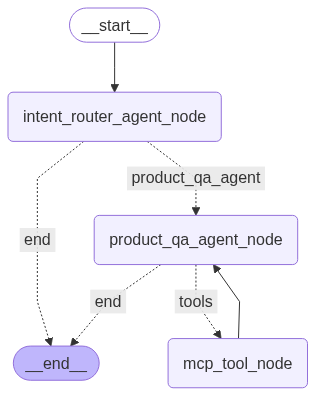

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the Graph

In [30]:
initial_state = {
    "messages": [{"role": "user", "content": "What is the weather today?"}],
    "available_tools": tool_descriptions
}
result = await graph.ainvoke(initial_state)

In [31]:
result 

{'messages': [{'role': 'user', 'content': 'What is the weather today?'},
  AIMessage(content="I'm here to help with shopping-related questions. Could you please clarify if you're looking for weather-related products or something else?", additional_kwargs={}, response_metadata={})],
 'answer': "I'm here to help with shopping-related questions. Could you please clarify if you're looking for weather-related products or something else?",
 'available_tools': [{'name': 'get_formatted_item_context',
   'description': 'Get the top k context, each representing an inventory item for a given query.',
   'parameters': {'type': 'object',
    'properties': {'query': {'title': 'Query',
      'type': 'string',
      'description': 'The query to get the top k context for'},
     'top_k': {'default': 5,
      'title': 'Top K',
      'type': 'integer',
      'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
   'required': ['query'],
   'returns': {'type': 'string',


In [28]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions
}
result = await graph.ainvoke(initial_state)

In [29]:
result 

{'messages': [{'role': 'user',
   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'},
  AIMessage(content='Let me find the best options for earphones, a laptop bag, and something cool for kids from our available products.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_item_context', 'args': {'query': 'earphones', 'top_k': 5}, 'id': 'call_0', 'type': 'tool_call'}, {'name': 'get_formatted_item_context', 'args': {'query': 'laptop bag', 'top_k': 5}, 'id': 'call_1', 'type': 'tool_call'}, {'name': 'get_formatted_item_context', 'args': {'query': 'kids toys', 'top_k': 5}, 'id': 'call_2', 'type': 'tool_call'}]),
  ToolMessage(content='CallToolResult(content=[TextContent(type=\'text\', text="- B0C85LNB75: Wireless Earbuds Headphones Bluetooth 5.3, 50H Playtime Over Ear Buds with Noise Cancelling Mic, LED Display, Stereo Bass Bluetooth Earbuds with Earhooks, IP7 Waterproof Earphones for Sports Workout Superior 